In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Create the Linear Layer

In [5]:
class Linear:
    def __init__(self,fan_in,fan_out, bias=True,):
        self.weight = torch.randn((fan_in,fan_out),generator=None)/fan_in**0.5 # using kaiming initialisation by default
        self.bias = torch.zeros(fan_out) if bias else None
        self.fan_in  = fan_in
        self.fan_out  = fan_out

    def __call__(self,x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out
    
    def parameters(self,):
        return [self.weight]+ ([] if self.bias is None else [self.bias])
    
    def __repr__(self) -> str:
        return f'Linear Layer with n_inp = {self.fan_in}, n_out = {self.fan_out}'


In [35]:
# example on how to use the layer
#batch_size = 32
#l1 = Linear(3,10)
#print(l1.weight.shape)
#x = torch.randn((batch_size, 3))
#op = l1(x)
#op.shape

torch.Size([3, 10])


torch.Size([32, 10])

### Create the BatchNorm1d Layer

In [ ]:
## somer layers, like batchnorm have slightly different behaviour during training and inference,
# eg - we are calculating running mean during training only and using batch mean/std to calculate output value
# but during inference, we are using running mean/std calculated during training to calculate the output

In [6]:
class BatchNorm1d:
    def __init__(self,num_features, eps = 1e-05, momentum = 0.1,affine =True,track_running_stats=True):
        self.num_features= num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        self.training = True
        
        if affine: # parameters trained with backprop
            self.gain  = torch.ones(1,num_features)
            self.bias = torch.zeros (1,num_features)

        if self.track_running_stats: # buffers trained with a running 'momentum' update
            self.mean_running = torch.zeros(1,num_features)
            self.std_running = torch.ones(1,num_features)


    def __call__(self,x): #pytorch won't have a .out atrribute, we are creating it so we can track/plot the statistics later

        if self.training:
            xmean = x.mean(0,keepdim=True) # using the batch mean/std during training
            xvar = x.var(0,keepdim=True) # note, using var, not std coz we need to add epsilon later
        else:
            xmean = self.mean_running # using the running mean/std if not training
            xvar  = self.std_running 

        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        self.out = self.gain * xhat + self.bias

        if self.training and self.track_running_stats:
            with torch.no_grad(): # used during inference, but calculated during training, nothing to optimise here hence using the context manager
                self.mean_running = (1-self.momentum)*self.mean_running + self.momentum *xmean 
                self.std_running = (1-self.momentum)*self.std_running + self.momentum * xvar 
        
        return self.out
    
    def parameters(self,):
        return [self.gain, self.bias]
    
    def __repr__(self) -> str:
        return f'Batch Norm 1D layer with num_features = {self.num_features}, n_out = {self.fan_out}'

In [61]:
# example on how to use the layer
#l1 = Linear(3,10)
#l2 = BatchNorm1d(10)

#batch_size = 32
#x = torch.randn((batch_size, 3))
#op_linear = l1(x)
#op_batchnorm = l2(op_linear)
#op_batchnorm.shape


torch.Size([32, 10])

### Creating the non linearity layer, Tanh


In [7]:
class Tanh: # just calls torch.tanh on an input tensor, no parameters
    def __call__ (self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self,):
        return []


### Creating the network

In [65]:
n_embd = 10 # dimensionality of char embedding vectors 
n_hidden = 100 # number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647) # for reproducability

C = torch.randn((vocab_size, n_embd),generator=g) # embedding matrix, trained during backprop, initlialized using random gaussian

layers = [
    Linear(n_embd*block_size,n_hidden ), Tanh(),
    Linear(         n_hidden,n_hidden ), Tanh(),
    Linear(         n_hidden,n_hidden ), Tanh(),
    Linear(         n_hidden,n_hidden ), Tanh(),
    Linear(         n_hidden,n_hidden ), Tanh(),
    Linear(         n_hidden,vocab_size ),   
]

### applying intilisation techniques we had discussed earlier

In [66]:
with torch.no_grad():
    # last layer - > make less confident, before training we want the logit to be roughly all zeros(same,zeros used for convention)
    # and logits = Xprevlayer * weights + bias 
    # so to decrease logits we decrease weights
    layers[-1].weight *= 0.1

    # for all other layers, apply the gain(if we are using tanh later we need to use --> 5/3 in the previous linear layer)
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *=5/3 

parameters = [C] + [ p for layer in layers for p in layer.parameters()]
print(len(parameters))
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad=True

13
46497


In [67]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors

    for layer in layers:
        x  = layer(x)

    loss = F.cross_entropy(x, Yb) # loss function


    # backward pass
    for layer in layers: # After debug, take out retain_grad
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad(): # tracking the ratio of std of the update to the actual data that is getting updated during gradient descent
        # bascially its a ratio of how great are these updates wrt the values of the tensors 
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    if i>1000:
        break

      0/ 200000: 3.2986


### Visualising the histogram of forward pass for tanh layers
Case1  = If we do not use a gain, layer.weight *=1

Case2  = If we do not use a large gain, layer.weight *=large value say 4

Case3  = If we use the recommended gain, layer.weight *=5/3


layer 1 (      Tanh): mean +0.02, std 0.63, saturated: 3.28%
layer 3 (      Tanh): mean +0.00, std 0.47, saturated: 0.00%
layer 5 (      Tanh): mean +0.01, std 0.41, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.36, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.33, saturated: 0.00%


what happens here is that the first layer is okay but the further layers output start shrinking/squashing towards zero, 
hence saturation is neglible, too much of squashing is also not good
This happens because tanh is a squashing function and to reduce the extent of the squashing we should multiple the values with some value >1, although not too big
      


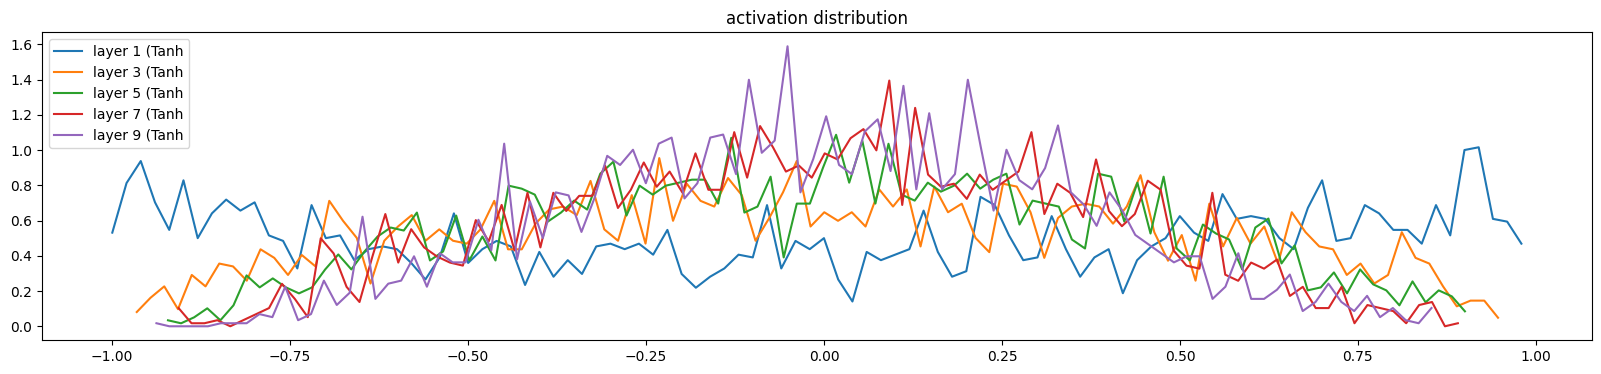

In [27]:
# Case 1 - Using gain =1 , equivalent to not using a gain

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# we call a value saturated if t.abs() > 0.97
for i, layer in enumerate(layers[:-1]): # note: exclude the output(softmax) layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

explanation = """\n\nwhat happens here is that the first layer is okay but the further layers output start shrinking/squashing towards zero, 
hence saturation is neglible, too much of squashing is also not good
This happens because tanh is a squashing function and to reduce the extent of the squashing we should multiple the values with some value >1 to fight the squashing, although not too big
      """

print(explanation)

layer 1 (      Tanh): mean +0.05, std 0.86, saturated: 47.44%
layer 3 (      Tanh): mean -0.02, std 0.84, saturated: 41.16%
layer 5 (      Tanh): mean -0.01, std 0.84, saturated: 40.00%
layer 7 (      Tanh): mean -0.04, std 0.83, saturated: 39.78%
layer 9 (      Tanh): mean +0.00, std 0.84, saturated: 42.56%


what happens here is that the first layer is okay but the further layers output start shrinking/squashing towards zero, 
hence saturation is neglible, too much of squashing is also not good


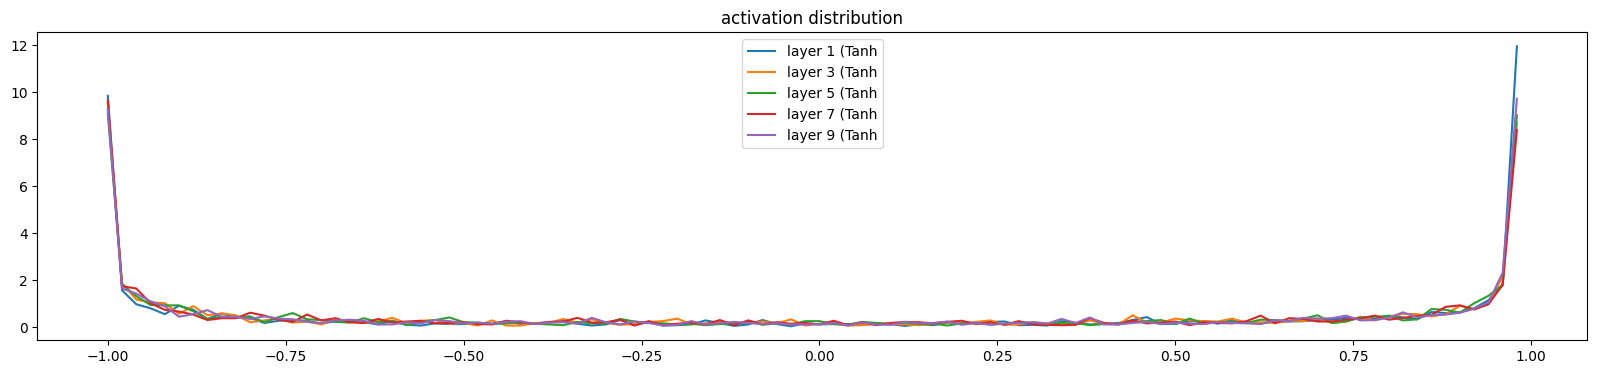

In [31]:
# Case 2 - Using high value of gain, eg 3, 


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# we call a value saturated if t.abs() > 0.97
for i, layer in enumerate(layers[:-1]): # note: exclude the output(softmax) layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

explanation = """\n\nSince we used a high value of gain the outputs become too big and end up in the tail regions of tanh, hence saturation is high"""

print(explanation)

layer 1 (      Tanh): mean -0.04, std 0.74, saturated: 18.41%
layer 3 (      Tanh): mean -0.01, std 0.69, saturated: 8.88%
layer 5 (      Tanh): mean +0.01, std 0.66, saturated: 6.75%
layer 7 (      Tanh): mean -0.01, std 0.65, saturated: 5.31%
layer 9 (      Tanh): mean +0.01, std 0.65, saturated: 4.16%


 Here we have used the recommended value of gain in kaiming initialisation, 5/3 if we have tanh layers applied after out linear layer.
Notice that the extent of saturation is not very high and the too much squashing(like case 1) is also not happening 


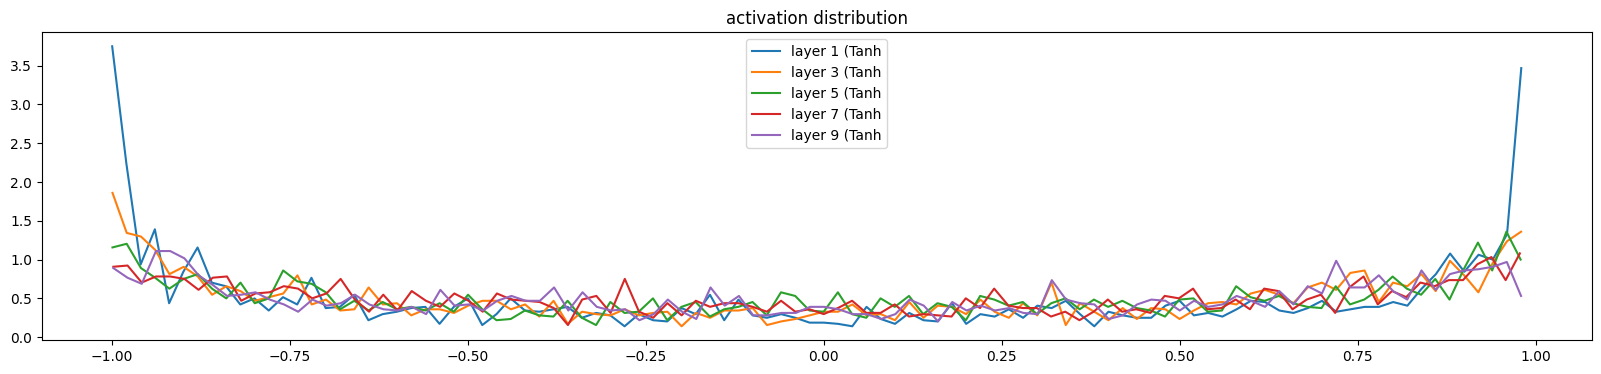

In [41]:
# Case 2 - Using recommended value of gain when using tanh, 5/3


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# we call a value saturated if t.abs() > 0.97
for i, layer in enumerate(layers[:-1]): # note: exclude the output(softmax) layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

explanation = """\n\n Here we have used the recommended value of gain in kaiming initialisation, 5/3 if we have tanh layers applied after out linear layer.
Notice that the extent of saturation is not very high and the too much squashing(like case 1) is also not happening """

print(explanation)

# visualising the gradient distributions

layer 1 (      Tanh): mean -0.000038, std 2.894241e-03
layer 3 (      Tanh): mean +0.000021, std 2.710061e-03
layer 5 (      Tanh): mean +0.000024, std 2.776251e-03
layer 7 (      Tanh): mean +0.000006, std 2.559649e-03
layer 9 (      Tanh): mean -0.000029, std 2.101523e-03


 Here we have used the recommended value of gain in kaiming initialisation, 5/3 if we have tanh layers applied after out linear layer.
Notice that the extent of saturation is not very high and the too much squashing(like case 1) is also not happening 


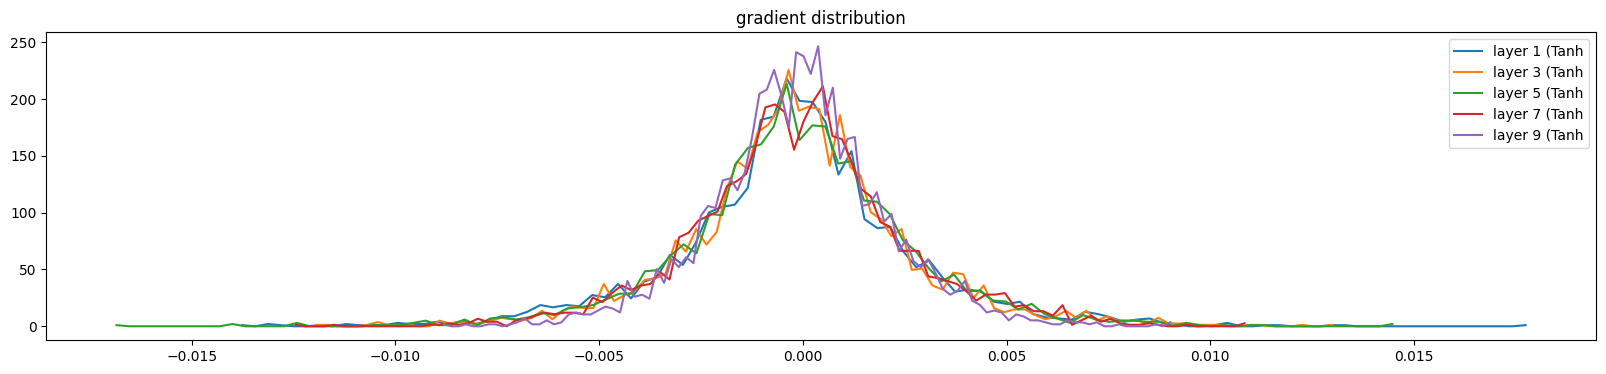

In [69]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

explanation = """\n\n Here we have used the recommended value of gain in kaiming initialisation, 5/3 if we have tanh layers applied after out linear layer.
Notice that the extent of saturation is not very high and the too much squashing(like case 1) is also not happening """

print(explanation)

### visualizing the gradients of the parameters

weight   (27, 10) | mean +0.000191 | std 9.687679e-03 | grad:data ratio 9.675916e-03
weight  (30, 100) | mean -0.000140 | std 8.746634e-03 | grad:data ratio 2.881295e-02
weight (100, 100) | mean +0.000024 | std 6.606151e-03 | grad:data ratio 3.912649e-02
weight (100, 100) | mean -0.000027 | std 6.007414e-03 | grad:data ratio 3.561645e-02
weight (100, 100) | mean -0.000094 | std 5.851147e-03 | grad:data ratio 3.468569e-02
weight (100, 100) | mean +0.000004 | std 4.835675e-03 | grad:data ratio 2.901317e-02
weight  (100, 27) | mean +0.000000 | std 2.111578e-02 | grad:data ratio 3.028064e-01


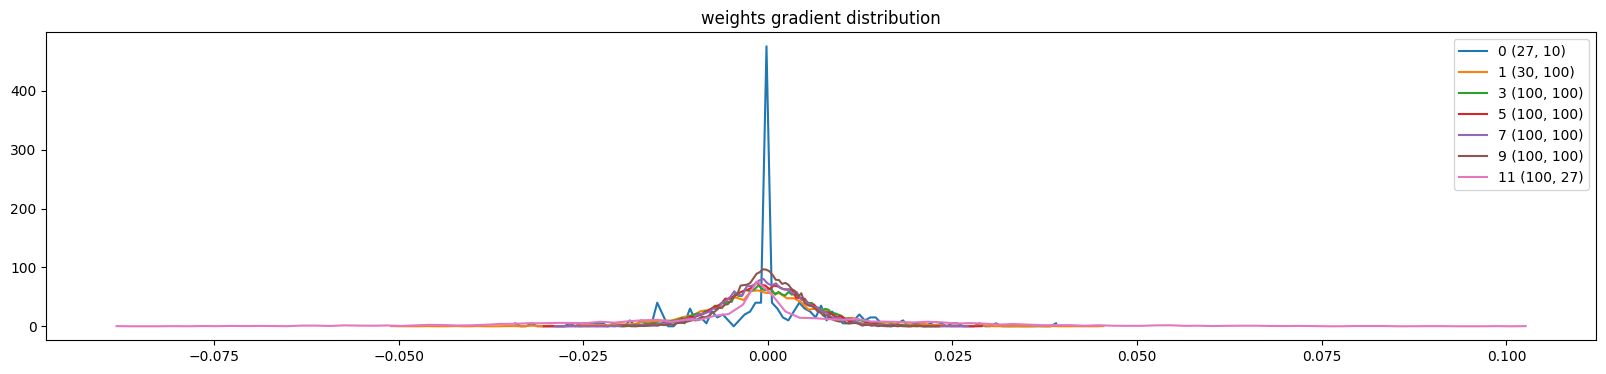

In [71]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### plotting the update ratios

Note that the updates evolve over time/iterations, and they start stabilizing as we have higher iterations


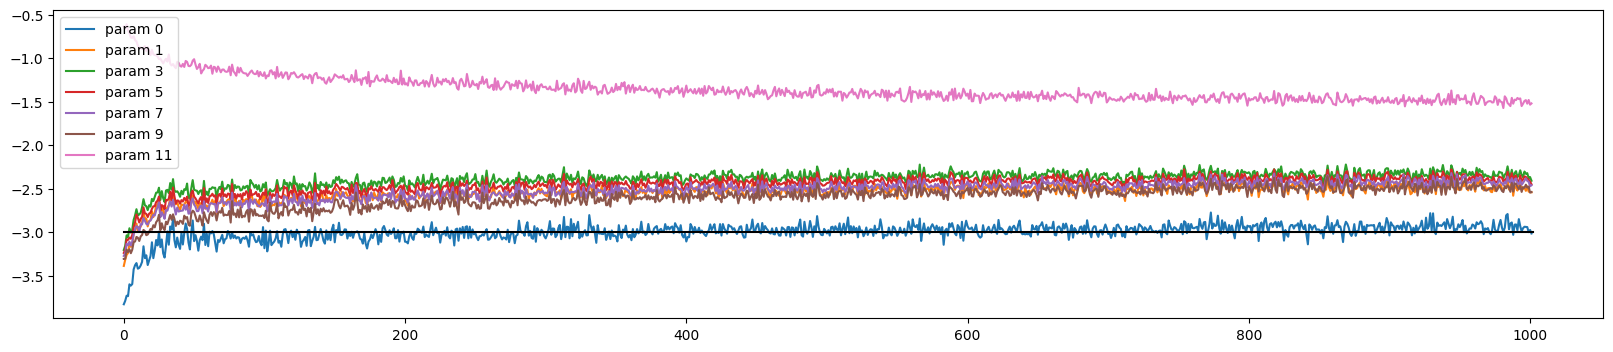

In [72]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

explanation = """Note that the updates evolve over time/iterations, and they start stabilizing as we have higher iterations.
Last layer is an outlier(pink), this is because we artificially decreased the values of the softmax layer by layers[-1].weight *= 0.1, but notice that is stabilises after iterations as model starts learning """
print(explanation)

### fully linear case of zero non-linearities

In [51]:
n_embd = 10 # dimensionality of char embedding vectors 
n_hidden = 100 # number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647) # for reproducability

C = torch.randn((vocab_size, n_embd),generator=g) # embedding matrix, trained during backprop, initlialized using random gaussian

layers = [
    Linear(n_embd*block_size,n_hidden ),# Tanh(),
    Linear(         n_hidden,n_hidden ),# Tanh(),
    Linear(         n_hidden,n_hidden ),# Tanh(),
    Linear(         n_hidden,n_hidden ),# Tanh(),
    Linear(         n_hidden,n_hidden ),# Tanh(),
    Linear(         n_hidden,vocab_size ),  
]

with torch.no_grad():
    # last layer - > make less confident, before training we want the logit to be roughly all zeros(same,zeros used for convention)
    # and logits = Xprevlayer * weights + bias 
    # so to decrease logits we decrease weights
    layers[-1].weight *= 0.1

    # for all other layers, apply the gain(if we are using tanh later we need to use --> 5/3 in the previous linear layer)
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *=1

parameters = [C] + [ p for layer in layers for p in layer.parameters()]
print(len(parameters))
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad=True

13
46497


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors

    for layer in layers:
        x  = layer(x)

    loss = F.cross_entropy(x, Yb) # loss function


    # backward pass
    for layer in layers: # After debug, take out retain_grad
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2205


### using gain = 5/3


layer 0 (    Linear): mean -0.04, std 1.65, saturated: 57.97%
layer 1 (    Linear): mean -0.13, std 2.71, saturated: 73.66%
layer 2 (    Linear): mean -0.19, std 4.40, saturated: 82.03%
layer 3 (    Linear): mean +0.21, std 7.25, saturated: 89.50%
layer 4 (    Linear): mean -0.09, std 12.30, saturated: 94.09%


Text(0.5, 1.0, 'activation distribution')

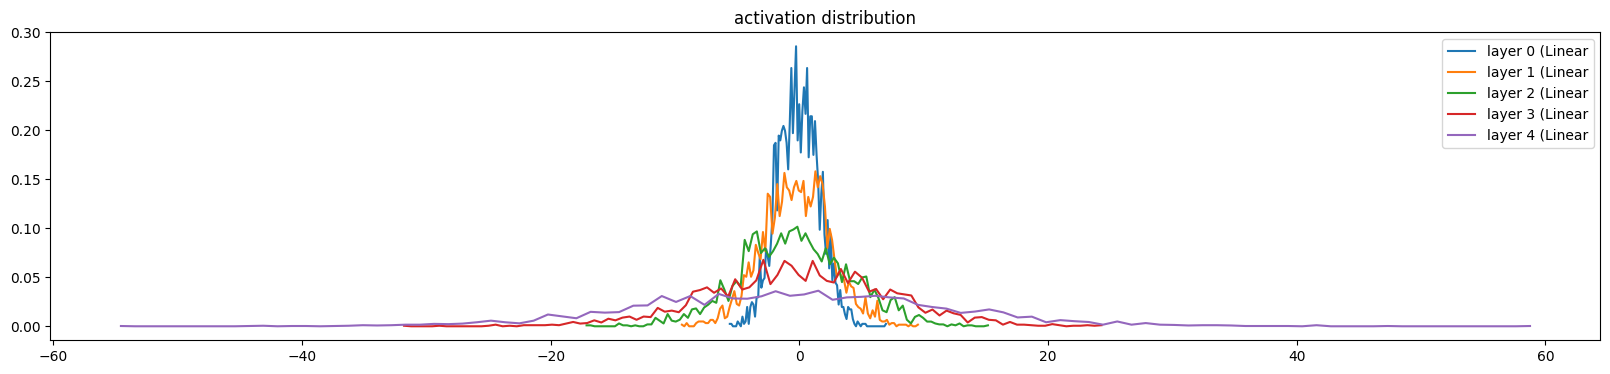

In [47]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# we call a value saturated if t.abs() > 0.97
for i, layer in enumerate(layers[:-1]): # note: exclude the output(softmax) layer
  if isinstance(layer, Linear): #changed to linear coz no tanh now
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean -0.000068, std 2.431391e-03
layer 1 (    Linear): mean -0.000002, std 1.443192e-03
layer 2 (    Linear): mean +0.000008, std 8.254466e-04
layer 3 (    Linear): mean -0.000015, std 5.143603e-04
layer 4 (    Linear): mean +0.000008, std 3.156026e-04


 you can notice that as we go further into to the next layers of the nn, the gradients start diminishing.
This is not a good place to be in


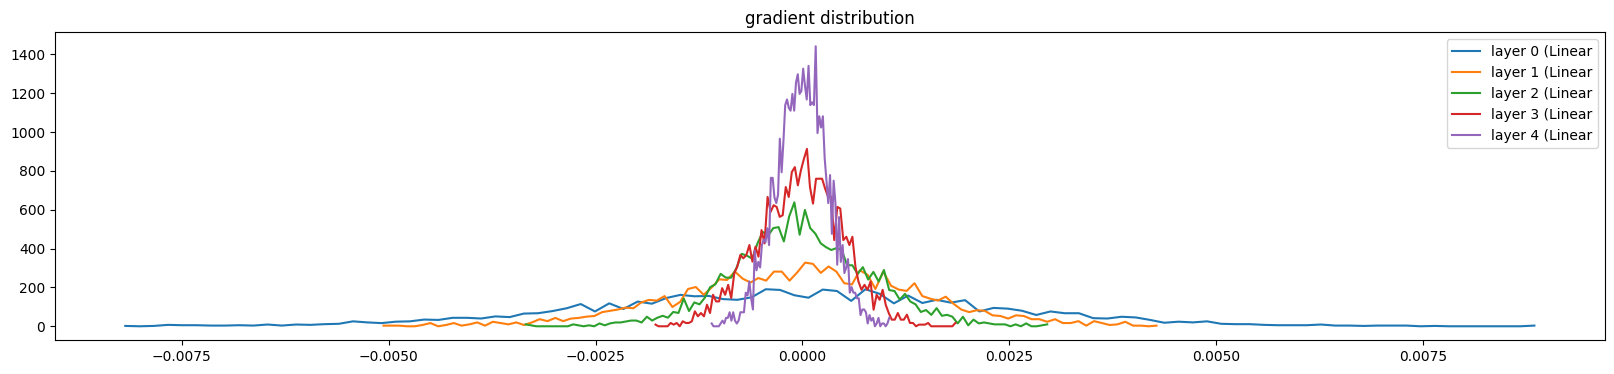

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

explanation = """\n\n you can notice that as we go further into to the next layers of the nn, the gradients start diminishing.
This is not a good place to be in, and it happens because of the chosen value of the gain(5/3 for the plot below), for the linear case, correct gain is 1 not 5/3"""

print(explanation)

### using gain = 1

layer 0 (    Linear): mean -0.02, std 1.01, saturated: 34.22%
layer 1 (    Linear): mean -0.05, std 0.96, saturated: 29.41%
layer 2 (    Linear): mean +0.02, std 0.97, saturated: 31.44%
layer 3 (    Linear): mean -0.02, std 0.96, saturated: 29.69%
layer 4 (    Linear): mean +0.02, std 0.92, saturated: 28.06%


Text(0.5, 1.0, 'activation distribution')

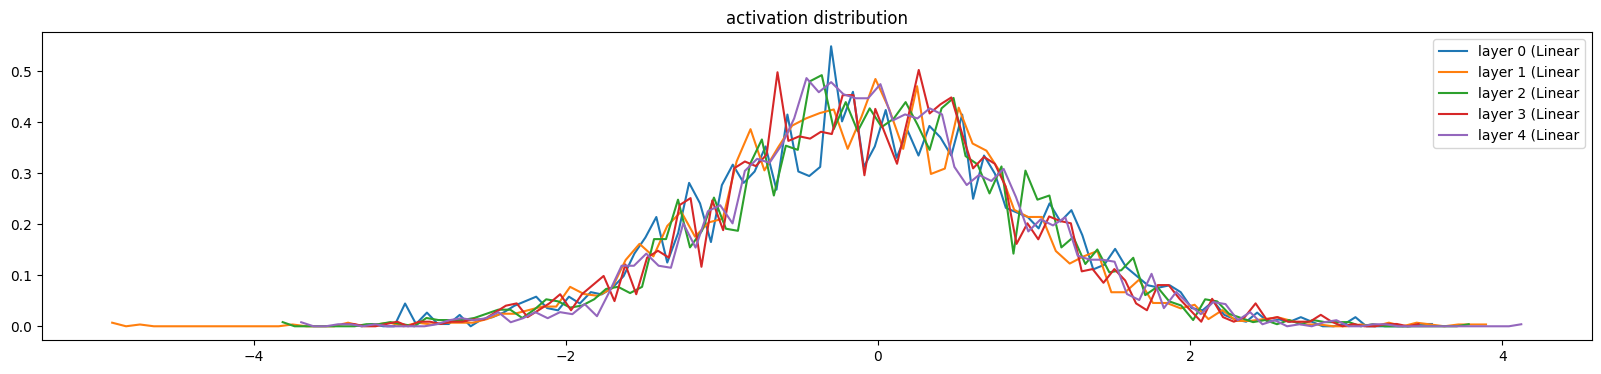

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# we call a value saturated if t.abs() > 0.97
for i, layer in enumerate(layers[:-1]): # note: exclude the output(softmax) layer
  if isinstance(layer, Linear): #changed to linear coz no tanh now
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean -0.000005, std 5.447487e-04
layer 1 (    Linear): mean +0.000011, std 5.142855e-04
layer 2 (    Linear): mean +0.000005, std 4.714239e-04
layer 3 (    Linear): mean -0.000003, std 4.201653e-04
layer 4 (    Linear): mean +0.000002, std 3.666223e-04


Text(0.5, 1.0, 'gradient distribution')

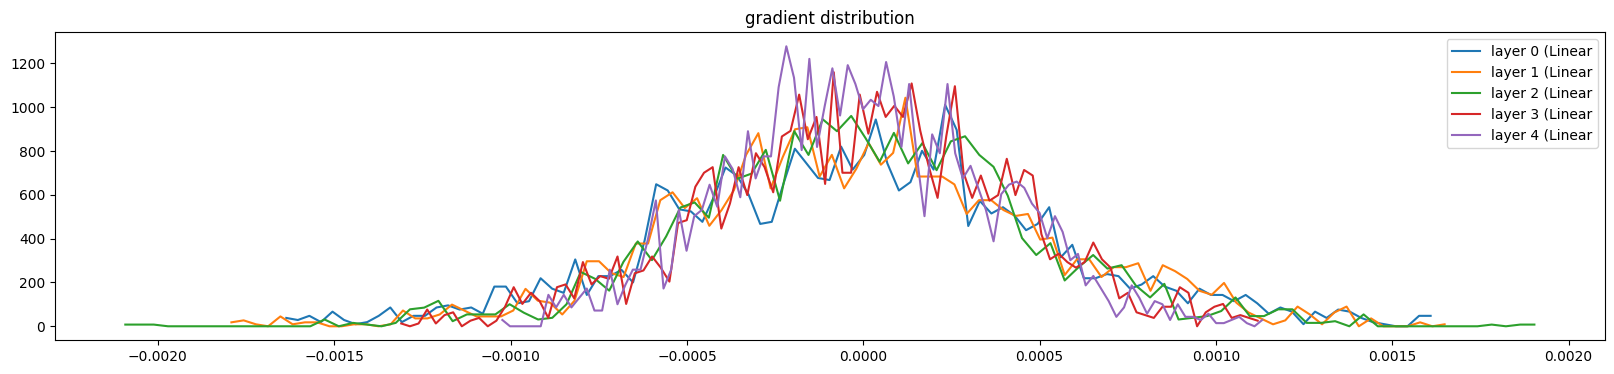

In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


## Using BatchNorm layers as well

In [80]:
n_embd = 10 # dimensionality of char embedding vectors 
n_hidden = 100 # number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647) # for reproducability

C = torch.randn((vocab_size, n_embd),generator=g) # embedding matrix, trained during backprop, initlialized using random gaussian

layers = [
    Linear(n_embd*block_size,n_hidden ), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ),  BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,vocab_size ), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer - > make less confident, before training we want the logit to be roughly all zeros(same,zeros used for convention)
    # and logits = Xprevlayer * weights + bias 
    # so to decrease logits we decrease weights, batchnorm doesn't have 'weight' it has 'gain' as defined in the class
    layers[-1].gain *= 0.1

    # for all other layers, apply the gain(if we are using tanh later we need to use --> 5/3 in the previous linear layer)
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *=5/3 

parameters = [C] + [ p for layer in layers for p in layer.parameters()]
print(len(parameters))
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad=True

25
47551


In [81]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors

    for layer in layers:
        x  = layer(x)

    loss = F.cross_entropy(x, Yb) # loss function


    # backward pass
    for layer in layers: # After debug, take out retain_grad
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad(): # tracking the ratio of std of the update to the actual data that is getting updated during gradient descent
        # bascially its a ratio of how great are these updates wrt the values of the tensors 
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    if i>1000: 
        break

      0/ 200000: 3.3117


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.38%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.16%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 1.75%


Text(0.5, 1.0, 'activation distribution')

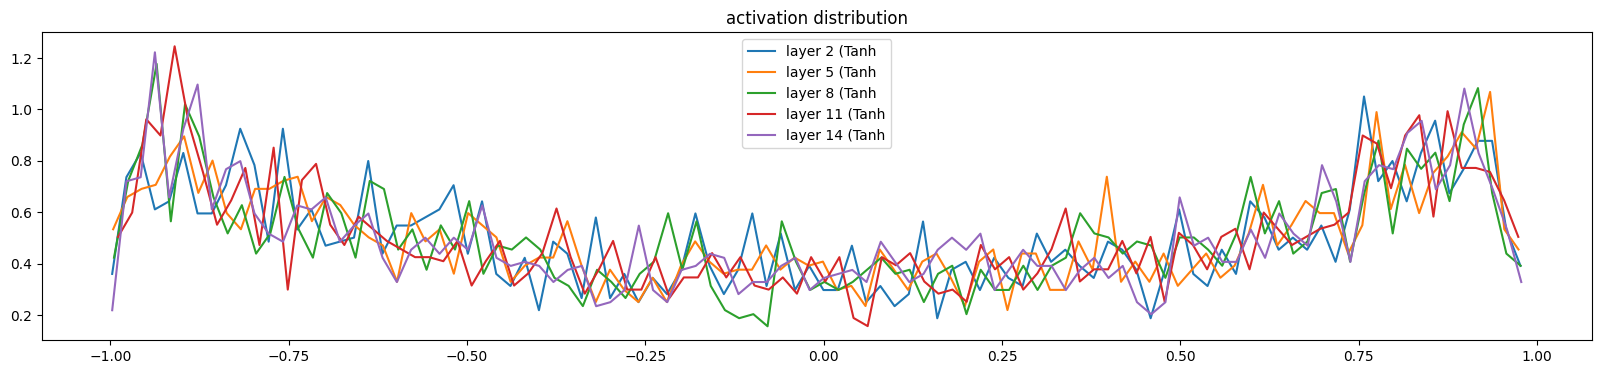

In [82]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
# we call a value saturated if t.abs() > 0.97
for i, layer in enumerate(layers[:-1]): # note: exclude the output(softmax) layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.895000e-03
layer 5 (      Tanh): mean +0.000000, std 3.423685e-03
layer 8 (      Tanh): mean +0.000000, std 3.003625e-03
layer 11 (      Tanh): mean +0.000000, std 2.925282e-03
layer 14 (      Tanh): mean -0.000000, std 2.823761e-03


Text(0.5, 1.0, 'gradient distribution')

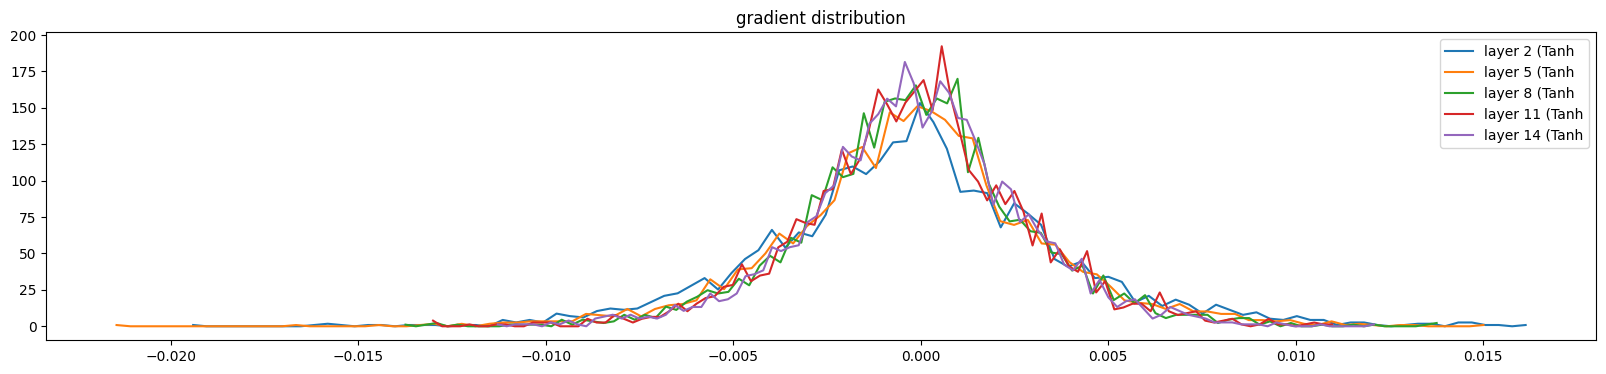

In [83]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.128134e-02 | grad:data ratio 1.126987e-02
weight  (30, 100) | mean +0.000231 | std 8.867509e-03 | grad:data ratio 2.950056e-02
weight   (1, 100) | mean +0.000662 | std 6.276991e-03 | grad:data ratio 3.454413e-01
weight   (1, 100) | mean -0.000276 | std 6.816105e-03 | grad:data ratio 2.312871e-01
weight (100, 100) | mean -0.000033 | std 6.877905e-03 | grad:data ratio 4.136152e-02
weight   (1, 100) | mean +0.000031 | std 5.515030e-03 | grad:data ratio 2.810586e-01
weight   (1, 100) | mean +0.000308 | std 5.654372e-03 | grad:data ratio 2.176798e-01
weight (100, 100) | mean +0.000034 | std 6.041216e-03 | grad:data ratio 3.636321e-02
weight   (1, 100) | mean -0.000723 | std 5.138546e-03 | grad:data ratio 2.925088e-01
weight   (1, 100) | mean -0.001035 | std 5.297416e-03 | grad:data ratio 1.994839e-01
weight (100, 100) | mean +0.000041 | std 5.849598e-03 | grad:data ratio 3.556965e-02
weight   (1, 100) | mean -0.000089 | std 5.992961e-03 | grad:data

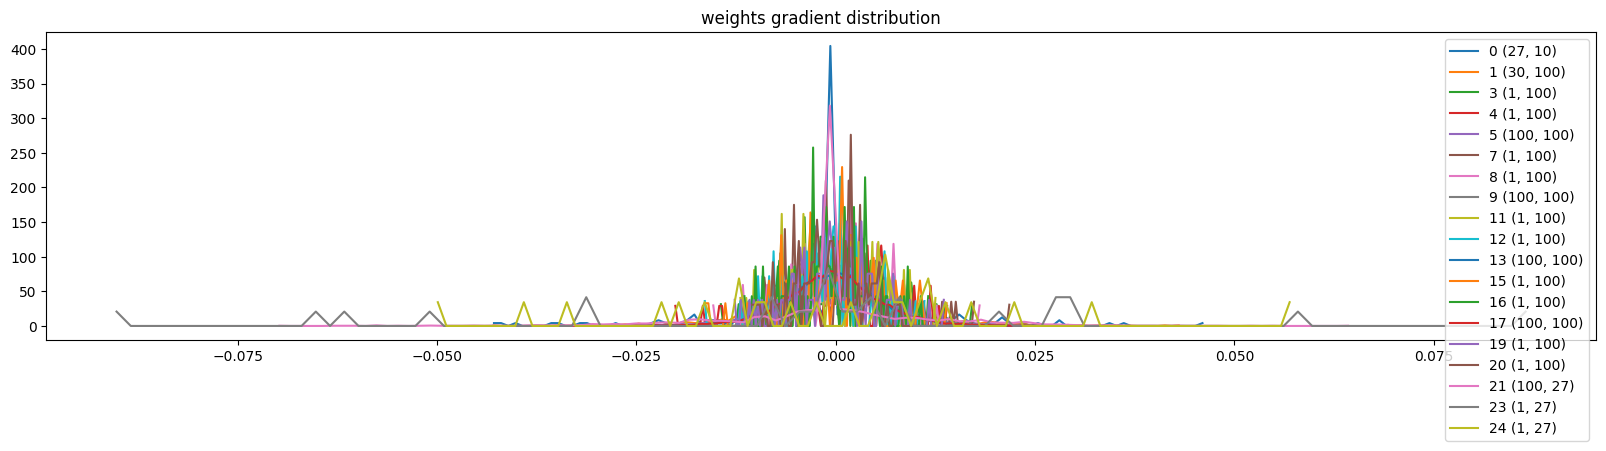

In [86]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

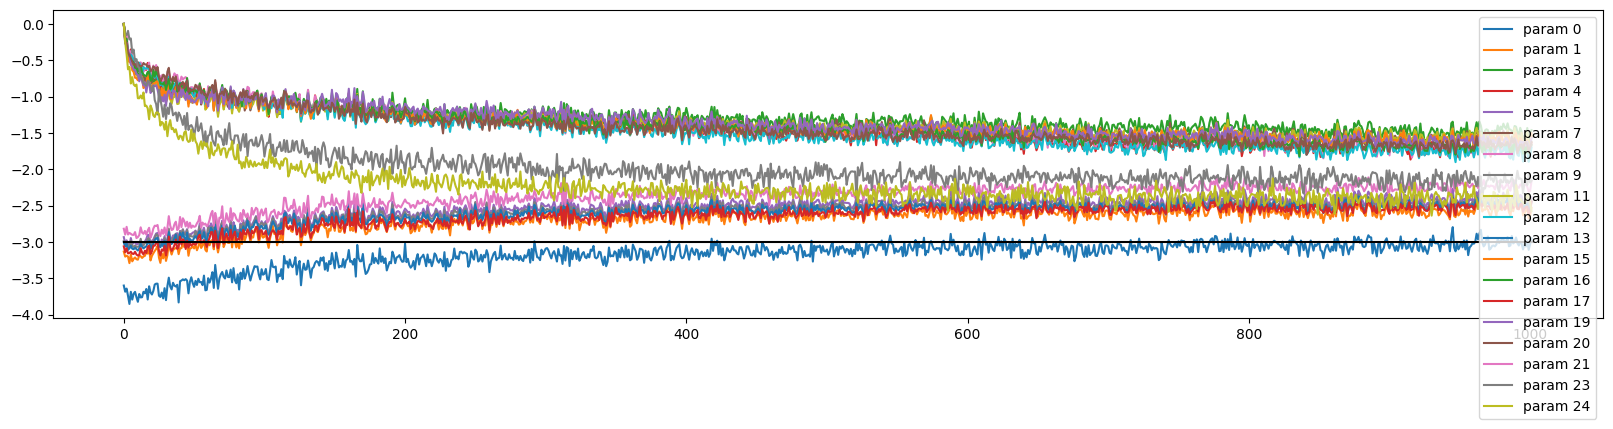

In [87]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
# we get very similar performace as earlier using the batch norm layers in the architecture
#now the performance of our network is not bottlenecked by the problems in optimisation, but probably because limited context
# we can try to use better architectures to imrpove upon it